# Pinecone

Workflow:

Embedding: You store a large corpus of documents in a vector database, where each document is represented as a vector embedding.

Query: When a user inputs a query, it is also converted into a vector embedding.

Search: The vector database performs a similarity search to find the most relevant document vectors based on the query vector.

Generation: The retrieved documents are fed into the generative model, which produces an answer by augmenting the response with the retrieved information.

In [6]:
from pinecone import Pinecone, ServerlessSpec
import os

pinecone_api_key = "pcsk_2N3Xuo_MJbFM6dEKPvChPtM8zb4WBnTrbeQAeewAvzEj7G7N8bRFctuKBdwQG1wL2nGGE9"

# pinecone_api_key = os.getenv("PINECONE_API_KEY")
# print(pinecone_api_key)

pc = Pinecone(api_key=pinecone_api_key)



In [7]:
index_name = "quickstart"

pc.create_index(
    name=index_name,
    dimension=1024, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

# pinecone.init(api_key=pinecone_api_key, environment="us-west1-gcp")
# pinecone.create_index(name="example-index", dimension=1536, metric="cosine")

PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': 'd3385052130b314d918ea5203ffd4cd7', 'Date': 'Wed, 15 Jan 2025 12:03:32 GMT', 'Server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [47]:
from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

vectors = []

pc.upsert(index="example-index", vectors=vectors)


ValidationError: 1 validation error for OpenAIEmbeddings
  Value error, Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. [type=value_error, input_value={'model': 'text-embedding...20, 'http_client': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [8]:
data = [
    {"id": "vec1", "text": "Apple is a popular fruit known for its sweetness and crisp texture."},
    {"id": "vec2", "text": "The tech company Apple is known for its innovative products like the iPhone."},
    {"id": "vec3", "text": "Many people enjoy eating apples as a healthy snack."},
    {"id": "vec4", "text": "Apple Inc. has revolutionized the tech industry with its sleek designs and user-friendly interfaces."},
    {"id": "vec5", "text": "An apple a day keeps the doctor away, as the saying goes."},
    {"id": "vec6", "text": "Apple Computer Company was founded on April 1, 1976, by Steve Jobs, Steve Wozniak, and Ronald Wayne as a partnership."}
]

embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[d['text'] for d in data],
    parameters={"input_type": "passage", "truncate": "END"}
)
print(embeddings[0])

{'vector_type': dense, 'values': [0.04913330078125, -0.01306915283203125, ..., -0.0196990966796875, -0.0110321044921875]}


In [9]:
# Wait for the index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

index = pc.Index(index_name)

vectors = []
for d, e in zip(data, embeddings):
    vectors.append({
        "id": d['id'],
        "values": e['values'],
        "metadata": {'text': d['text']}
    })

index.upsert(
    vectors=vectors,
    namespace="ns1"
)

{'upserted_count': 6}

In [10]:
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'ns1': {'vector_count': 6}},
 'total_vector_count': 6}


In [ ]:
query_vector = embeddings.embed_query("Explain AI technologies")
result = index.query(queries=[query_vector], top_k=5)
print(result)


In [11]:
query = "Tell me about the tech company known as Apple."

embedding = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"
    }
)

Indexes

An index stores vector embeddings for similarity search.
Each index can have a specified metric (cosine, dot-product, or Euclidean).

Namespaces

Used for logically grouping vectors in an index for isolation or multi-tenancy.

Metadata Filtering

Attach metadata (e.g., category, tags) to vectors and filter results during queries.

In [ ]:
result = index.query(
    queries=[query_vector], 
    top_k=5,
    filter={"category": "science"}
)


In [ ]:
results = index.query(
    namespace="ns1",
    vector=embedding[0].values,
    top_k=3,
    include_values=False,
    include_metadata=True
)

print(results)

6. Pinecone Use Cases with LLMs

RAG Systems: Retrieve knowledge stored in vectors to generate more accurate answers.

Semantic Search: Search through unstructured data (e.g., documents) based on meaning.

Chatbots & Q&A Systems: Store embeddings of documents for context-based chat interactions.

Recommendation Engines: Suggest similar content based on embeddings.

Anomaly Detection: Detect patterns or anomalies in datasets.

7. Advanced Features

Hybrid Search: Combines keyword and vector search for better accuracy.

Batch Processing: Supports batch insertion and queries for scalability.

Data Persistence: Ensures data durability and backups.

APIs and SDKs: Easy-to-use REST APIs and SDKs for Python and Node.js.

Integration with ML Frameworks: Works with HuggingFace, OpenAI, and LangChain.

In [ ]:
%pip install pinecone

In [70]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load PDF
loader = PyPDFLoader("docs/django-api-tutorial-latest.pdf")  # Replace with your PDF file
pages = loader.load_and_split()

# Split text into smaller chunks for embedding
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
chunks = splitter.split_documents(pages)

print(f"Number of chunks: {len(chunks)}")
print(chunks)



Number of chunks: 82
[Document(metadata={'source': 'docs/django-api-tutorial-latest.pdf', 'page': 0}, page_content='Building APIs with Django and Django\nRest Framework\nRelease 2.0\nAgiliq\nAug 07, 2021'), Document(metadata={'source': 'docs/django-api-tutorial-latest.pdf', 'page': 2}, page_content='Contents\n1 Introductions 3\n1.1 Who is this book for? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n1.2 How to read this book? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n2 Setup, Models and Admin 5\n2.1 Creating a project . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5\n2.2 Database setup . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5\n2.3 Creating models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 6\n2.4 Activating models . . . . . . . . . . . . . . . . . . . . . . . . . .

In [91]:
index_name = "pdfchucks"

pc.create_index(
    name=index_name,
    dimension=1024, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

# pinecone.init(api_key=pinecone_api_key, environment="us-west1-gcp")
# pinecone.create_index(name="example-index", dimension=1536, metric="cosine")

In [92]:
# Extract text data for embeddings
inputs = [doc.page_content for doc in chunks]
print(inputs)

embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=inputs,
    parameters={"input_type": "passage", "truncate": "END"}
)
print(embeddings[0])

print(index.describe_index_stats())

['Building APIs with Django and Django\nRest Framework\nRelease 2.0\nAgiliq\nAug 07, 2021', 'Contents\n1 Introductions 3\n1.1 Who is this book for? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n1.2 How to read this book? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n2 Setup, Models and Admin 5\n2.1 Creating a project . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5\n2.2 Database setup . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5\n2.3 Creating models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 6\n2.4 Activating models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7\n3 A simple API with pure Django 9\n3.1 The endpoints and the URLS . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 9\n3.2 Connecting urls to 

In [93]:
import time
# Wait for the index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

index = pc.Index(index_name)

vectors = []
for idx, (doc, embedding) in enumerate(zip(chunks, embeddings)):
    vectors.append({
        "id": f"doc-{idx}",  # Unique ID for each document
        "values": embedding['values'],  # Extract only the values
        "metadata": {
            "source": doc.metadata['source'],  # Store source metadata
            "page": doc.metadata['page'],     # Store page metadata
            "text": doc.page_content          # Store original text
        }
    })

index.upsert(
    vectors=vectors,
    namespace="ns1"
)

{'upserted_count': 82}

In [96]:
query = "Tell me about the django-rest settings."

embedding = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"
    }
)

In [97]:
results = index.query(
    namespace="ns1",
    vector=embedding[0].values,
    top_k=4,
    include_values=False,
    include_metadata=True
)

print(results)

{'matches': [{'id': 'doc-7',
              'metadata': {'page': 5.0,
                           'source': 'docs/django-api-tutorial-latest.pdf',
                           'text': 'Building APIs with Django and Django Rest '
                                   'Framework, Release 2.0\n'
                                   '2 Contents'},
              'score': 0.834403694,
              'values': []},
             {'id': 'doc-9',
              'metadata': {'page': 7.0,
                           'source': 'docs/django-api-tutorial-latest.pdf',
                           'text': 'Building APIs with Django and Django Rest '
                                   'Framework, Release 2.0\n'
                                   '4 Chapter 1. Introductions'},
              'score': 0.833245814,
              'values': []},
             {'id': 'doc-46',
              'metadata': {'page': 33.0,
                           'source': 'docs/django-api-tutorial-latest.pdf',
                           'text'

In [71]:
openai_api_key = os.getenv("OPENAI_API_KEY")

In [72]:

from langchain.embeddings.openai import OpenAIEmbeddings


embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=openai_api_key)


In [77]:
index_name = "textada-002"

pc.create_index(
    name=index_name,
    dimension=1536, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

In [78]:
# Wait for the index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

index = pc.Index(index_name)

vectors = []
for idx, doc in enumerate(chunks):
    # Get embedding for the current chunk of text
    embedding = embeddings.embed_query(doc.page_content)
    
    # Prepare vector for upsert
    vectors.append({
        "id": f"doc-{idx}",  # Unique ID for each document
        "values": embedding,  # Embed the content
        "metadata": {
            "source": doc.metadata['source'],  # Store source metadata
            "page": doc.metadata['page'],     # Store page metadata
            "text": doc.page_content          # Store original text
        }
    })

# Upsert the vectors into Pinecone (correct way)
try:
    index.upsert(vectors=vectors, namespace="ns1")
    print(f"Upserted {len(vectors)} vectors to index '{index_name}'")
except Exception as e:
    print(f"Error during upsert: {e}")

Upserted 82 vectors to index 'textada-002'


In [79]:
# Output the number of chunks and details
print(f"Number of chunks: {len(chunks)}")
for chunk in chunks:
    print(chunk)

Number of chunks: 82
page_content='Building APIs with Django and Django
Rest Framework
Release 2.0
Agiliq
Aug 07, 2021' metadata={'source': 'docs/django-api-tutorial-latest.pdf', 'page': 0}
page_content='Contents
1 Introductions 3
1.1 Who is this book for? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3
1.2 How to read this book? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3
2 Setup, Models and Admin 5
2.1 Creating a project . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5
2.2 Database setup . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5
2.3 Creating models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 6
2.4 Activating models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7
3 A simple API with pure Django 9
3.1 The endpoints and the URLS .

In [ ]:
# Create OpenAIEmbeddings instance
# embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=openai_api_key)

# Define the query
query = "Tell me about the django-rest settings."

# Embed the query using OpenAI's API (text-embedding-ada-002 model)
embedding_Q = embeddings.embed_query(query) 

# Connect to the Pinecone index
index = pc.Index(index_name)


In [87]:

# Query the Pinecone index
results = index.query(
    namespace="ns1",
    vector=embedding_Q,  # Use the OpenAI-generated embedding vector
    top_k=2,  # Number of top results to return
    include_values=False,  # Whether to include the values of the vectors
    include_metadata=True  # Include metadata with the results
)

# Print the results
print(results)

{'matches': [{'id': 'doc-46',
              'metadata': {'page': 33.0,
                           'source': 'docs/django-api-tutorial-latest.pdf',
                           'text': 'Building APIs with Django and Django Rest '
                                   'Framework, Release 2.0\n'
                                   '30 Chapter 6. More views and viewsets'},
              'score': 0.850220501,
              'values': []},
             {'id': 'doc-9',
              'metadata': {'page': 7.0,
                           'source': 'docs/django-api-tutorial-latest.pdf',
                           'text': 'Building APIs with Django and Django Rest '
                                   'Framework, Release 2.0\n'
                                   '4 Chapter 1. Introductions'},
              'score': 0.844251812,
              'values': []}],
 'namespace': 'ns1',
 'usage': {'read_units': 6}}


In [5]:

# To get the unique host for an index, 
# see https://docs.pinecone.io/guides/data/target-an-index
index_name = "pdfchucks"
index = pc.Index(index_name)

# index = pc.Index(host=index_name, api_key=pinecone_api_key)

# Fetch data by IDs
result = index.fetch(ids=["doc-46", "doc-47"], namespace="ns1")  # Provide a list of document IDs to fetch
print(result)


{'namespace': 'ns1',
 'usage': {'read_units': 1},
 'vectors': {'doc-46': {'id': 'doc-46',
                        'metadata': {'page': 33.0,
                                     'source': 'docs/django-api-tutorial-latest.pdf',
                                     'text': 'Building APIs with Django and '
                                             'Django Rest Framework, Release '
                                             '2.0\n'
                                             '30 Chapter 6. More views and '
                                             'viewsets'},
                        'values': [0.0507507324,
                                   0.00814819336,
                                   -0.0263214111,
                                   -0.0221862793,
                                   0.0220794678,
                                   -0.042175293,
                                   -0.0145568848,
                                   0.0430908203,
                                

In [ ]:
%pip install chromadb sentence-transformers


In [8]:
import chromadb

# Initialize ChromaDB client
client = chromadb.Client()

# Create a new collection for storing embeddings
miniLM_L6_coll= client.get_or_create_collection("mini_embeddings")
gte_large_coll= client.get_or_create_collection("large_embeddings")


In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

mini model

In [13]:


# Load a pre-trained embedding model
mini_model = SentenceTransformer('all-MiniLM-L6-v2')

# Example documents
documents = [
    "The Eiffel Tower is located in Paris, France.",
    "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor.",
    "The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, and other materials.",
    "Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.",
]

# Generate embeddings for documents
mini_embeddings = mini_model.encode(documents)


In [14]:
# Add documents and embeddings to the collection
for i, doc in enumerate(documents):
    miniLM_L6_coll.add(
        documents=[doc],  # Text content
        metadatas=[{"id": i}],  # Metadata (optional)
        ids=[str(i)],  # Unique ID for each document
        embeddings=[mini_embeddings[i].tolist()]  # Embeddings
    )

print(f"Collection size: {miniLM_L6_coll.count()}")


Collection size: 4


large model

In [17]:


# Load a pre-trained embedding model
large_model = SentenceTransformer('thenlper/gte-large')

# Example documents
documents = [
    "The Eiffel Tower is located in Paris, France.",
    "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor.",
    "The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, and other materials.",
    "Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.",
]

# Generate embeddings for documents
large_embeddings = large_model.encode(documents)

In [18]:
# Add documents and embeddings to the collection
for i, doc in enumerate(documents):
    gte_large_coll.add(
        documents=[doc],  # Text content
        metadatas=[{"id": i}],  # Metadata (optional)
        ids=[str(i)],  # Unique ID for each document
        embeddings=[large_embeddings[i].tolist()]  # Embeddings
    )

print(f"Collection size: {gte_large_coll.count()}")


Collection size: 4


## Query ChromaDB

Document: The Eiffel Tower is located in Paris, France.
Metadata: {'id': 0}
Score: 0.25111401081085205

Document: The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, and other materials.
Metadata: {'id': 2}
Score: 1.5685498714447021

Document: The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor.
Metadata: {'id': 1}
Score: 1.621516466140747



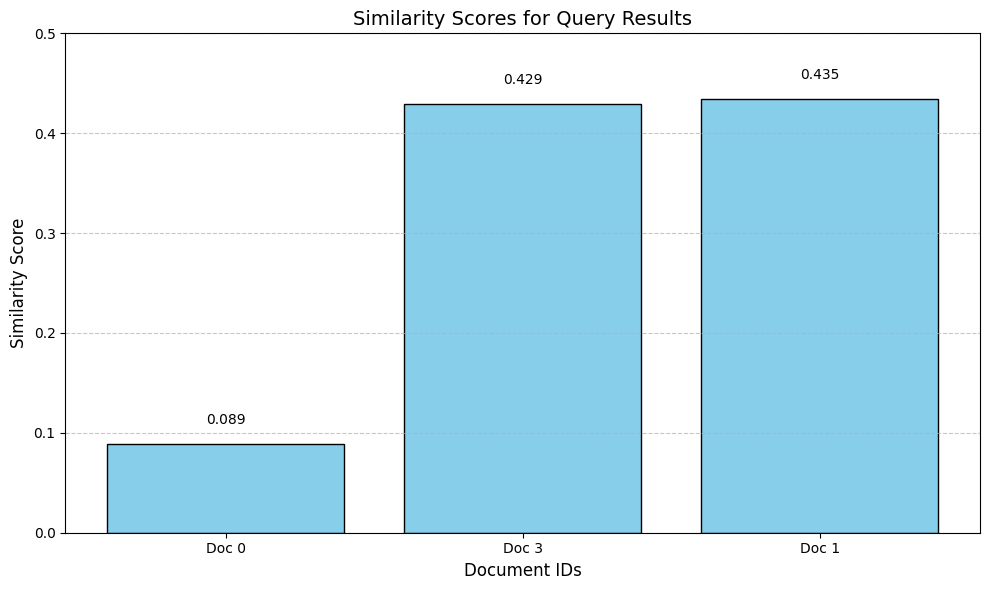

In [34]:
# User query
query = "Where is the Eiffel Tower located?"

# Generate embedding for the query
mini_query_embedding = mini_model.encode([query])[0]

# Search the collection for similar documents
results = miniLM_L6_coll.query(
    query_embeddings=[mini_query_embedding.tolist()],
    n_results=3  # Number of results to return
)

# Display results
for doc, metadata, score in zip(results['documents'][0], results['metadatas'][0], results['distances'][0]):
    print(f"Document: {doc}")
    print(f"Metadata: {metadata}")
    print(f"Score: {score}")
    print()





# Data from query results
documents = [
    "The Eiffel Tower is located in Paris, France.",
    "Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.",
    "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor."
]
scores = [0.08909699320793152, 0.42878612875938416, 0.43456733226776123]
document_ids = ["Doc 0", "Doc 3", "Doc 1"]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(document_ids, scores, color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Similarity Scores for Query Results", fontsize=14)
plt.xlabel("Document IDs", fontsize=12)
plt.ylabel("Similarity Score", fontsize=12)

# Annotate bars with scores
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=10)

plt.ylim(0, 0.5)  # Adjust y-axis limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# User query
query = "Where is the Eiffel Tower located?"

# Generate embedding for the query
large_query_embedding = large_model.encode([query])[0]

# Search the collection for similar documents
results = gte_large_coll.query(
    query_embeddings=[large_query_embedding.tolist()],
    n_results=3  # Number of results to return
)

# Display results
for doc, metadata, score in zip(results['documents'][0], results['metadatas'][0], results['distances'][0]):
    print(f"Document: {doc}")
    print(f"Metadata: {metadata}")
    print(f"Score: {score}")
    print()


Document: The Eiffel Tower is located in Paris, France.
Metadata: {'id': 0}
Score: 0.08909699320793152

Document: Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.
Metadata: {'id': 3}
Score: 0.42878612875938416

Document: The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor.
Metadata: {'id': 1}
Score: 0.43456733226776123



##  Update the Collection

In [21]:
new_document = "The Colosseum is an oval amphitheater in the center of the city of Rome, Italy."
new_mini_embedding = mini_model.encode([new_document])[0]

miniLM_L6_coll.add(
    documents=[new_document],
    metadatas=[{"id": len(documents)}],
    ids=[str(len(documents))],
    embeddings=[new_mini_embedding.tolist()]
)


In [23]:
new_document = "The Colosseum is an oval amphitheater in the center of the city of Rome, Italy."
new_large_embedding = large_model.encode([new_document])[0]

gte_large_coll.add(
    documents=[new_document],
    metadatas=[{"id": len(documents)}],
    ids=[str(len(documents))],
    embeddings=[new_large_embedding.tolist()]
)


Add of existing embedding ID: 4
Insert of existing embedding ID: 4


## Deleting Data

In [ ]:
miniLM_L6_coll.delete(ids=["0"])  # Delete the first document

## save the database in local directory

In [24]:
# client.persist(directory="db/chromadb_test_database")

# import chromadb

# Initialize Chroma client with persistence
client = chromadb.PersistentClient("db/chromadb_test_database")


### visulaize the vectore data
 Reduce dimensions using PCA or t-SNE
 Use PCA for faster results or t-SNE for detailed visualization
 Uncomment one of the following:

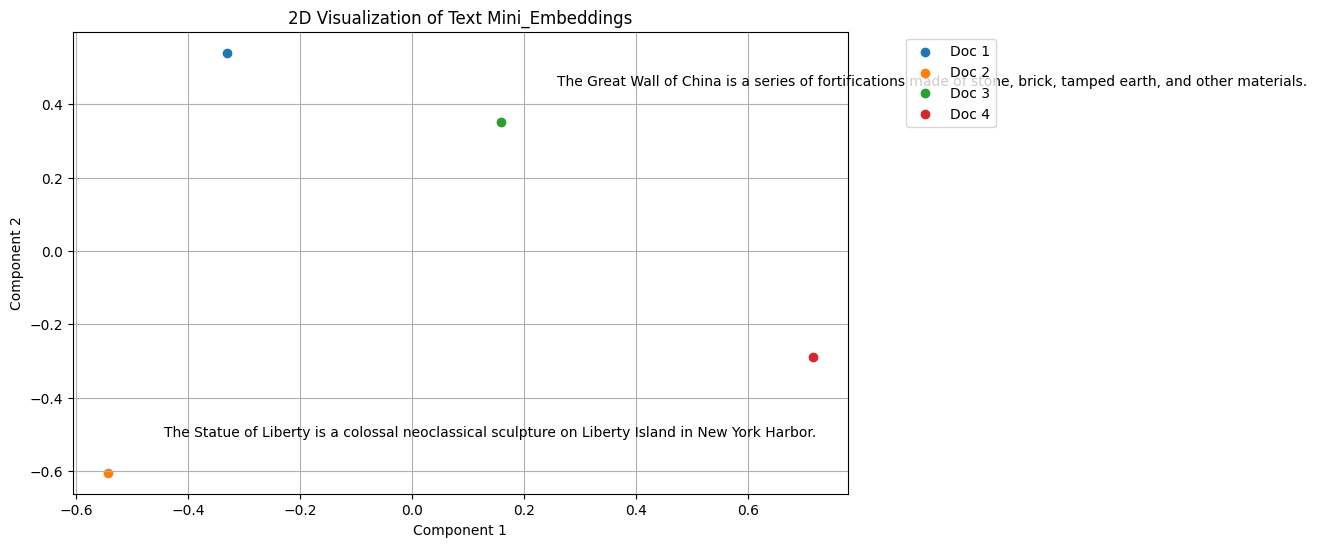

In [33]:

mini_reduced_embeddings = PCA(n_components=2).fit_transform(mini_embeddings)  # Faster
# reduced_embeddings = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)  # Slower but better for large datasets

# Plot the reduced embeddings
plt.figure(figsize=(10, 6))

# Scatter plot
for i, label in enumerate(documents):
    plt.scatter(mini_reduced_embeddings[i, 0], mini_reduced_embeddings[i, 1], label=f"Doc {i+1}")

# Annotate points with document names
for i, label in enumerate(documents):
    plt.annotate(label, (mini_reduced_embeddings[i, 0] + 0.1, mini_reduced_embeddings[i, 1] + 0.1))

plt.title("2D Visualization of Text Mini_Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

documents = [
    "The Eiffel Tower is located in Paris, France.",
    "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor.",
    "The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, and other materials.",
    "Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.",
]


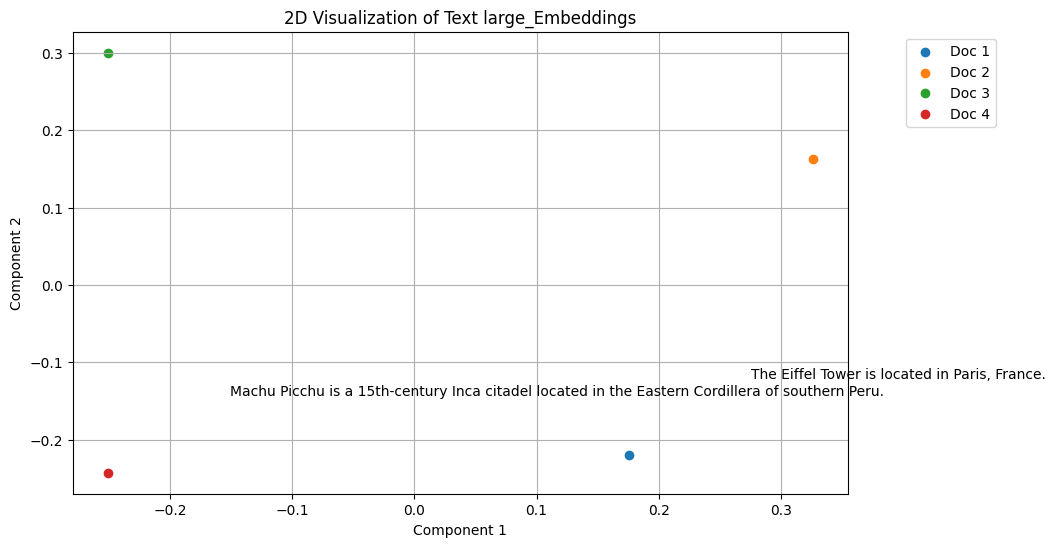

In [29]:

large_reduced_embeddings = PCA(n_components=2).fit_transform(large_embeddings)  # Faster
# reduced_embeddings = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)  # Slower but better for large datasets

# Plot the reduced embeddings
plt.figure(figsize=(10, 6))

# Scatter plot
for i, label in enumerate(documents):
    plt.scatter(large_reduced_embeddings[i, 0], large_reduced_embeddings[i, 1], label=f"Doc {i+1}")

# Annotate points with document names
for i, label in enumerate(documents):
    plt.annotate(label, (large_reduced_embeddings[i, 0] + 0.1, large_reduced_embeddings[i, 1] + 0.1))

plt.title("2D Visualization of Text large_Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

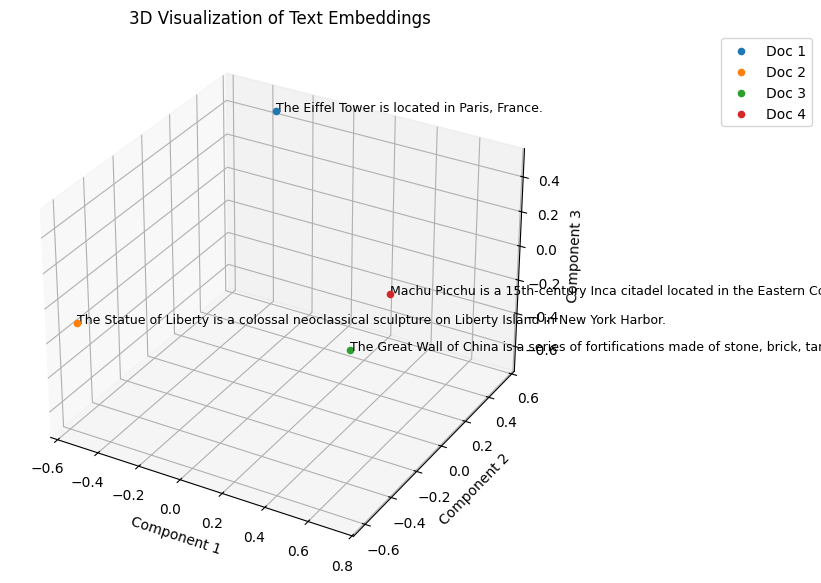

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensions to 3D
reduced_embeddings_3d = PCA(n_components=3).fit_transform(mini_embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for i, label in enumerate(documents):
    ax.scatter(
        reduced_embeddings_3d[i, 0],
        reduced_embeddings_3d[i, 1],
        reduced_embeddings_3d[i, 2],
        label=f"Doc {i+1}"
    )

# Annotate points with document names
for i, label in enumerate(documents):
    ax.text(
        reduced_embeddings_3d[i, 0],
        reduced_embeddings_3d[i, 1],
        reduced_embeddings_3d[i, 2],
        label,
        fontsize=9
    )

ax.set_title("3D Visualization of Text Embeddings")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()


In [10]:
from chromadb import Client
from chromadb.config import Settings
from IPython.display import display, Markdown
import json


# Initialize ChromaDB client with in-memory database
client = Client()

# Create or get a collection for items
collection = client.get_or_create_collection(name="product_recommendations")

# Step 1: Add item embeddings (e.g., products)
collection.add(
    embeddings=[
        [0.1, 0.2, 0.3],  # Product 1
        [0.4, 0.5, 0.6],  # Product 2
        [0.7, 0.8, 0.9]   # Product 3
    ],
    documents=["Product A", "Product B", "Product C"],
    metadatas=[{"category": "electronics"}, {"category": "fashion"}, {"category": "books"}],
    ids=["product1", "product2", "product3"]
)

# Step 2: Add user preference embeddings
collection.add(
    embeddings=[[0.7, 0.8, 0.9]],  # User preference embedding
    documents=["User Preference"],
    metadatas=[{"user_id": 123}],
    ids=["user123_pref"]
)





# Step 3: Query for recommendations
recommendations = collection.query(
    query_embeddings=[[0.7, 0.8, 0.9]],  # User preference embedding
    n_results=3  # Number of results to return
)

# recommendations = collection.query(
#     query_embeddings=[[0.7, 0.8, 0.9]],  # User preference embedding
#     n_results=3,  # Number of results to return
#     include=["embeddings", "documents", "metadatas", "distances"]  # Include embeddings in the output
# )


# Output the recommendations
# Convert JSON to a formatted string
formatted_json = json.dumps(recommendations, indent=4)

# Display as Markdown
display(Markdown(f"```json\n{formatted_json}\n```"))


Insert of existing embedding ID: product1
Insert of existing embedding ID: product2
Insert of existing embedding ID: product3
Add of existing embedding ID: product1
Add of existing embedding ID: product2
Add of existing embedding ID: product3
Insert of existing embedding ID: user123_pref
Add of existing embedding ID: user123_pref


```json
{
    "ids": [
        [
            "product3",
            "user123_pref",
            "product2"
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "Product C",
            "User Preference",
            "Product B"
        ]
    ],
    "uris": null,
    "data": null,
    "metadatas": [
        [
            {
                "category": "books"
            },
            {
                "user_id": 123
            },
            {
                "category": "fashion"
            }
        ]
    ],
    "distances": [
        [
            0.0,
            0.0,
            0.26999998092651367
        ]
    ],
    "included": [
        "distances",
        "documents",
        "metadatas"
    ]
}
```

In [12]:
recommendations = collection.query(
    query_embeddings=[[0.7, 0.8, 0.9]],
    n_results=3,
    where={"category": "books"}  # Only return items in the "books" category
)

# Convert JSON to a formatted string
formatted_json = json.dumps(recommendations, indent=2)

# Display as Markdown
display(Markdown(f"```json\n{formatted_json}\n```"))

```json
{
  "ids": [
    [
      "product3"
    ]
  ],
  "embeddings": null,
  "documents": [
    [
      "Product C"
    ]
  ],
  "uris": null,
  "data": null,
  "metadatas": [
    [
      {
        "category": "books"
      }
    ]
  ],
  "distances": [
    [
      0.0
    ]
  ],
  "included": [
    "distances",
    "documents",
    "metadatas"
  ]
}
```

In [13]:
recommendations = collection.query(
    query_embeddings=[[0.7, 0.8, 0.9]],
    n_results=3,
    where={
        "$and": [
            {"category": "books"},
            {"price": {"$lt": 20}}
        ]
    }
)

# Convert JSON to a formatted string
formatted_json = json.dumps(recommendations, indent=4)

# Display as Markdown
display(Markdown(f"```json\n{formatted_json}\n```"))

```json
{
    "ids": [
        []
    ],
    "embeddings": null,
    "documents": [
        []
    ],
    "uris": null,
    "data": null,
    "metadatas": [
        []
    ],
    "distances": [
        []
    ],
    "included": [
        "distances",
        "documents",
        "metadatas"
    ]
}
```